In [210]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [211]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures = pd.DataFrame (yen_futures, columns = ["Open", "High", "Low", "Change", "Settle", "Volume", "Previous Day Open Interest"])
yen_futures.head()

,Open,High,Low,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [212]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

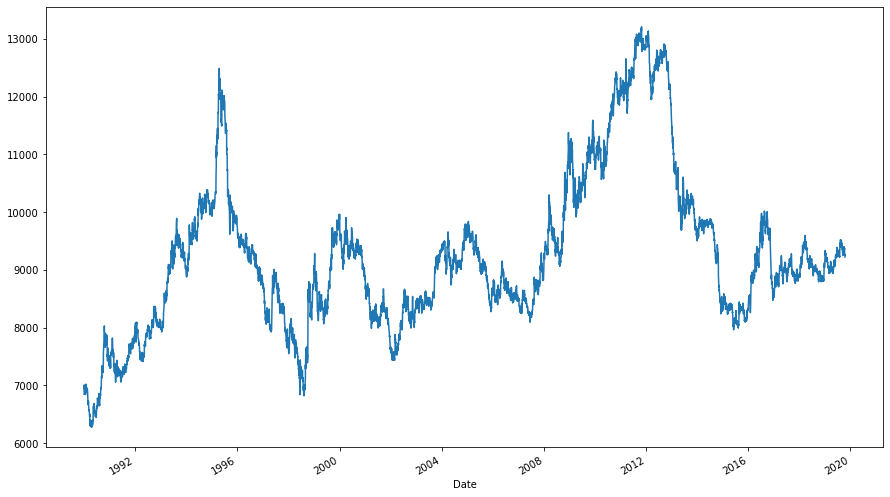

In [213]:
# Plot just the "Settle" column from the dataframe:
yen_futures ["Settle"].plot(figsize = (15,9))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [214]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"]) 

In [215]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_futures["Noise"] = ts_noise
yen_futures["Trend"] = ts_trend
yen_futures = pd.DataFrame (yen_futures, columns = ["Settle", "Noise", "Trend"])
yen_futures.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:xlabel='Date'>

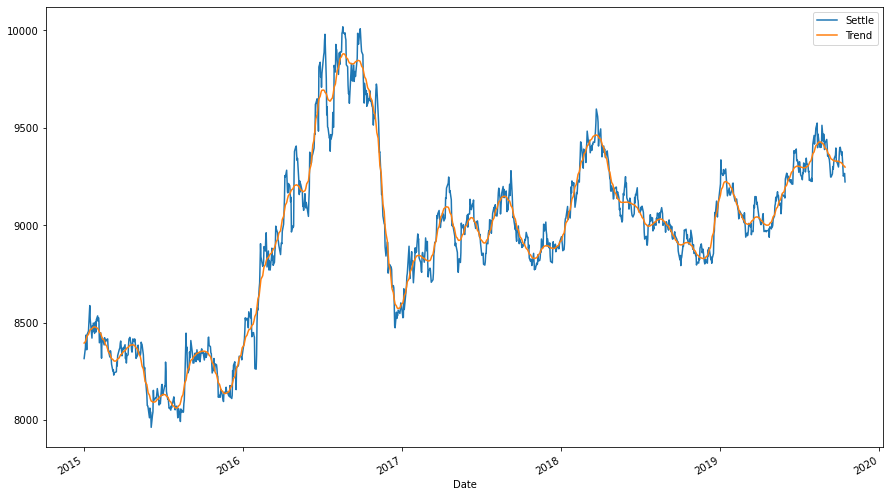

In [216]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_futures = yen_futures.loc["2015-01-01":, :]
yen_futures.plot(figsize = (15,9), y = ["Settle", "Trend"])


<AxesSubplot:xlabel='Date'>

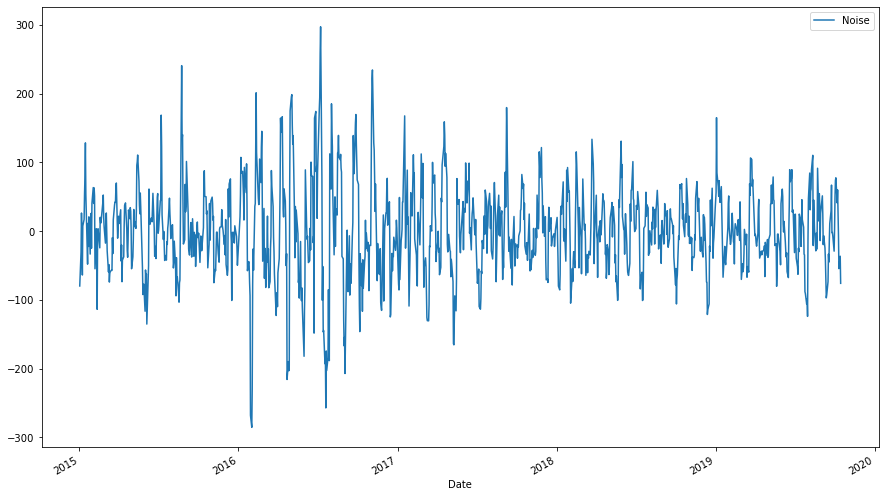

In [217]:
# Plot the Settle Noise
yen_futures = yen_futures.loc["2015-01-01":, :]
yen_futures.plot (figsize = (15,9), y = "Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [218]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [219]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1)) 


# Fit the model and assign it to a variable called results
results = model.fit()

In [220]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1205
Model:                     ARMA(2, 1)   Log Likelihood                -998.831
Method:                       css-mle   S.D. of innovations              0.554
Date:                Sat, 21 Nov 2020   AIC                           2007.662
Time:                        12:39:35   BIC                           2033.133
Sample:                             0   HQIC                          2017.255
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.016      0.623      0.533      -0.022       0.042
ar.L1.y        0.1770      0.378      0.468      0.640      -0.565       0.919
ar.L2.y        0.0502      0.030      1.651      0.099      -0.009       0.110
ma.L1.y       -0.2112      0.378     -0.559      0.576      -0.952       0.530
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0358           +0.0000j            3.0358            0.0000
AR.2           -6.5618           +0.0000j            6.5618            0.5000
MA.1            4.7344           +0.0000j            4.7344            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Settle Return Forecast'}>

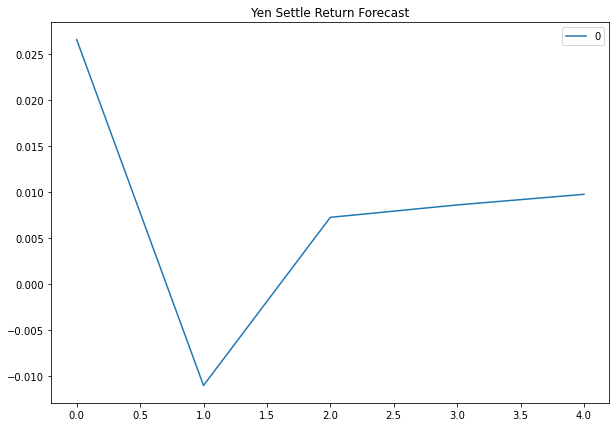

In [221]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize = (10,7),title="Yen Settle Return Forecast") 

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [233]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures["Settle"], order=(5, 1, 1))

# Fit the model
model.fit()

C:\Users\local.admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\local.admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [223]:
# Output model summary results:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 1205
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -6417.416
Method:                       css-mle   S.D. of innovations             49.735
Date:                Sat, 21 Nov 2020   AIC                          12850.832
Time:                        12:39:38   BIC                          12891.586
Sample:                             1   HQIC                         12866.180
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7592      1.418      0.535      0.592      -2.021       3.539
ar.L1.D.Settle    -0.7971      0.265     -3.011      0.003      -1.316      -0.278
ar.L2.D.Settle     0.0234      0.038      0.614      0.539      -0.051       0.098
ar.L3.D.Settle     0.0649      0.039      1.680      0.093      -0.011       0.141
ar.L4.D.Settle    -0.0096      0.038     -0.256      0.798      -0.083       0.064
ar.L5.D.Settle    -0.0641      0.032     -2.016      0.044      -0.126      -0.002
ma.L1.D.Settle     0.7647      0.265      2.885      0.004       0.245       1.284
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1848           -0.0000j            1.1848           -0.5000
AR.2           -1.1019           -1.3697j            1.7579           -0.3578
AR.3           -1.1019           +1.3697j            1.7579            0.3578
AR.4            1.6193           -1.2801j            2.0642           -0.1065
AR.5            1.6193           +1.2801j            2.0642            0.1065
MA.1           -1.3077           +0.0000j            1.3077            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen 5-Day Forecast'}>

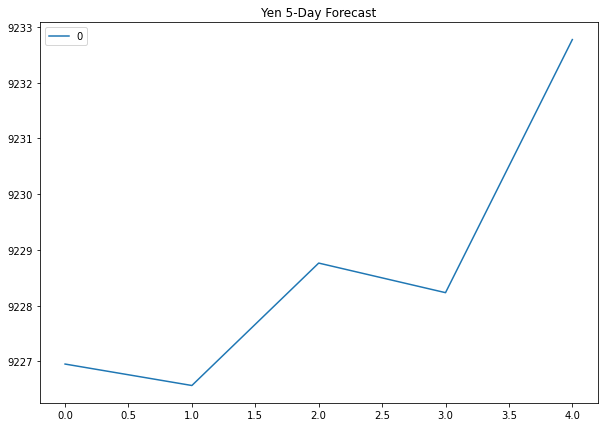

In [224]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize = (10,7),title="Yen 5-Day Forecast") 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [225]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [226]:
# Estimate a GARCH model:
from arch import arch_model
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures = pd.DataFrame (yen_futures, columns = ["Open", "High", "Low", "Change", "Settle", "Volume", "Previous Day Open Interest"])
yen_futures = yen_futures.loc["1990":"2019"]
returns = (yen_futures[["Settle"]].pct_change() * 100).dropna()
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1) 

# Fit the model
res = model.fit(disp="off") 

In [227]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sat, Nov 21 2020   Df Residuals:                     7510
Time:                        12:39:40   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [228]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [229]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [230]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [231]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


<AxesSubplot:>

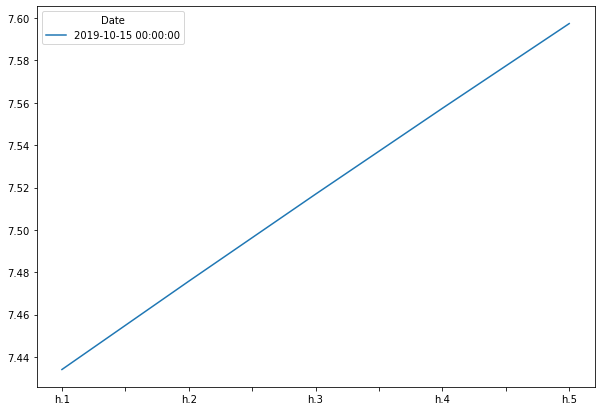

In [234]:
# Plot the final forecast
final.plot(figsize = (10,7)) 

---

# Conclusions

In [ ]:
# Based on this analysis, especially the results fro the GARCH volatility model, the projected increase in volatility         although it creates more risk also increases the reward profile should be more attractive as well. That being said, I       believe that additional fitting and testing (tim e periods, etc.) would bolster more confidence.
